In [1]:
from collections import defaultdict
from datetime import date
import itertools
import os
from pathlib import Path
import random
import time

import IPython.display

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

2022-08-09 22:11:15.016157: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
random.seed(42)

In [3]:
SOURCE_DATE_FORMAT = "%B %d, %Y"
TARGET_DATE_FORMAT = "%Y-%m-%d"

def add_start_stop(s):
    return "^" + s + "$"

def gen_date_pair():
    o = random.randrange(date.min.toordinal(), date.max.toordinal())
    d = date.fromordinal(o)
    x = d.strftime(SOURCE_DATE_FORMAT)
    y = d.strftime(TARGET_DATE_FORMAT)
    return (x,), (add_start_stop(y),)

gen_date_pair()

(('December 07, 7343',), ('^7343-12-07$',))

In [4]:
def date_dataset(n_samples, batch_size=32):
    dates = [gen_date_pair() for _ in range(n_samples)]
    return tf.data.Dataset.from_tensor_slices(dates) \
        .shuffle(n_samples) \
        .batch(batch_size, drop_remainder=True) \
        .map(lambda pair: (pair[:, 0], pair[:, 1])) \
        .prefetch(1)

for x, y in date_dataset(100).take(1):
    print(x)
    print(y)

tf.Tensor(
[[b'November 09, 3950']
 [b'September 30, 8054']
 [b'August 09, 4818']
 [b'October 01, 9269']
 [b'March 22, 3324']
 [b'February 03, 6631']
 [b'October 15, 2672']
 [b'May 27, 1603']
 [b'February 05, 2618']
 [b'December 12, 4347']
 [b'November 11, 1160']
 [b'August 05, 4190']
 [b'September 11, 7594']
 [b'November 09, 1868']
 [b'May 14, 9951']
 [b'September 03, 8768']
 [b'September 30, 799']
 [b'October 16, 5207']
 [b'April 20, 917']
 [b'June 20, 1834']
 [b'July 18, 8506']
 [b'March 23, 4366']
 [b'October 04, 2511']
 [b'December 16, 7771']
 [b'February 21, 9823']
 [b'September 29, 1174']
 [b'August 18, 75']
 [b'April 22, 5804']
 [b'September 19, 9254']
 [b'August 28, 1111']
 [b'July 31, 2473']
 [b'December 16, 8380']], shape=(32, 1), dtype=string)
tf.Tensor(
[[b'^3950-11-09$']
 [b'^8054-09-30$']
 [b'^4818-08-09$']
 [b'^9269-10-01$']
 [b'^3324-03-22$']
 [b'^6631-02-03$']
 [b'^2672-10-15$']
 [b'^1603-05-27$']
 [b'^2618-02-05$']
 [b'^4347-12-12$']
 [b'^1160-11-11$']
 [b'^4190-08-0

2022-08-09 22:11:16.297071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 22:11:16.762633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [5]:
class BatchPreprocessor:
    def __init__(self, training):
        self.training = training
        
    @tf.function
    def __call__(self, X, Y):
        X = source_preprocessor(X)
        Y_full = target_preprocessor(Y)
        Y = Y_full[:, 1:]
        
        if not self.training:
            return X, Y
       
        X_decoder = Y_full[:, :-1]
        X_decoder_length = tf.cast(tf.math.count_nonzero(X_decoder, axis=1), tf.int32)
        
        return (X, X_decoder, X_decoder_length), Y
        
def preprocess(ds, source_preprocessor, target_preprocessor, training=False):
    return ds.map(BatchPreprocessor(training))

train_set = date_dataset(5000)
val_set = date_dataset(1000)
test_set = date_dataset(1000)

source_preprocessor = keras.layers.TextVectorization(standardize=None, split="character", output_mode="int")
target_preprocessor = keras.layers.TextVectorization(standardize=None, split="character", output_mode="int")

source_preprocessor.adapt(train_set.map(lambda X, Y: X))
target_preprocessor.adapt(train_set.map(lambda X, Y: Y))

preprocessed_train_set = preprocess(train_set, source_preprocessor, target_preprocessor, training=True)
preprocessed_val_set = preprocess(val_set, source_preprocessor, target_preprocessor)
preprocessed_test_set = preprocess(test_set, source_preprocessor, target_preprocessor)


max_target_length = 0
for _, y in preprocessed_val_set:
    max_target_length = max(max_target_length, y.shape[1])
    
print(max_target_length)

11


In [6]:
source_vocab = set(c for c in source_preprocessor.get_vocabulary())
target_vocab = set(c for c in target_preprocessor.get_vocabulary())
source_vocab_size = len(source_vocab)
target_vocab_size = len(target_vocab)

In [7]:
target_vocab_start = target_preprocessor("^").numpy()[0]
target_vocab_end = target_preprocessor("$").numpy()[0]

print(target_vocab_start, target_vocab_end)

5 6


In [8]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "date_reformatting")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [9]:
class EncoderDecoder(keras.Model):
    def __init__(
        self, 
        source_vocab_size, 
        target_vocab_size, 
        target_vocab_start, 
        target_vocab_end, 
        max_target_length, 
        embedding_size=5, 
        n_neurons=32, 
        **kwargs,
    ):
        super().__init__(**kwargs)
        
        self.target_vocab_start = target_vocab_start
        self.target_vocab_end = target_vocab_end
        self.max_target_length = max_target_length
        
        self.source_embeddings = keras.layers.Embedding(source_vocab_size, embedding_size)
        self.target_embeddings = keras.layers.Embedding(target_vocab_size, embedding_size)
        self.encoder = keras.layers.LSTM(n_neurons, return_state=True)
        
        decoder_cell = keras.layers.LSTMCell(n_neurons)
        output_layer = keras.layers.Dense(target_vocab_size)
        
        training_sampler = tfa.seq2seq.sampler.TrainingSampler()
        self._training_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, training_sampler, output_layer=output_layer)
       
        inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(self.target_embeddings)
        self._inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
            decoder_cell, 
            inference_sampler,
            output_layer=output_layer,
            maximum_iterations=self.max_target_length,
            impute_finished=True,
        )
        
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
            
        
        if training:
            encoder_inputs, decoder_inputs, decoder_input_lengths = inputs
            
            encoder_embeddings = self.source_embeddings(encoder_inputs)
            decoder_embeddings = self.target_embeddings(decoder_inputs)
            encoder_outputs, state_h, state_c = self.encoder(encoder_embeddings)
            encoder_state = [state_h, state_c]
            
            final_outputs, final_state, final_sequence_lengths = self._training_decoder(
                decoder_embeddings,
                initial_state=encoder_state,
                sequence_length=decoder_input_lengths,
            )
        else:
            encoder_embeddings = self.source_embeddings(inputs)
            encoder_outputs, state_h, state_c = self.encoder(encoder_embeddings)
            encoder_state = [state_h, state_c]
            
            decoder_embedding_matrix = self.target_embeddings.variables[0]
            start_tokens = tf.cast(tf.fill([inputs.shape[0]], self.target_vocab_start), tf.int32)
            end_token = self.target_vocab_end
            final_outputs, final_state, final_sequence_lengths = self._inference_decoder(
                decoder_embedding_matrix,
                initial_state=encoder_state,
                start_tokens=start_tokens,
                end_token=end_token,
            )
        
        pad_len = tf.math.maximum(0, self.max_target_length - tf.reduce_max(final_sequence_lengths))
        padded_output = tf.pad(final_outputs.rnn_output, [[0, 0], [0, pad_len], [0, 0]])
        Y_proba = tf.nn.softmax(padded_output)
        return Y_proba
    

def build_model(
    source_vocab_size, 
    target_vocab_size, 
    target_vocab_start, 
    target_vocab_end, 
    max_target_length, 
    optimizer=keras.optimizers.Adam,
    embedding_size=5, 
    n_neurons=32, 
    n_layers=2, 
    learning_rate=1e-3, 
    clipnorm=1.0,
):
    model = EncoderDecoder(
        source_vocab_size, 
        target_vocab_size, 
        target_vocab_start,
        target_vocab_end,
        max_target_length, 
        embedding_size=embedding_size, 
        n_neurons=n_neurons,
    )
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate, clipnorm=clipnorm),
        metrics=["sparse_categorical_accuracy"],
    )
    
    return model

In [10]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

def find_best_learning_rate(
    train_set,
    val_set,
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      train_set,
      epochs=1,
      steps_per_epoch=n_steps,
      validation_data=val_set,
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 10.
    return best_learning_rate

In [11]:
def train_model(
    train_set, 
    val_set, 
    compiled_model, 
    callbacks=None,
    n_epochs=20,
    steps_per_epoch=None,
    tensorboard_callback=keras.callbacks.TensorBoard,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    builtin_callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        get_tensorboard_cb(callback=tensorboard_callback),
    ]
    
    history = compiled_model.fit(
        train_set,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_set,
        callbacks=callbacks + builtin_callbacks,
    )

2022-08-09 22:11:23.310492: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-09 22:11:23.786036: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


150/150 [==============================] - 10s 30ms/step - loss: 2.4084 - sparse_categorical_accuracy: 0.1983 - val_loss: 3.3647 - val_sparse_categorical_accuracy: 0.0674


0.08317638635635376

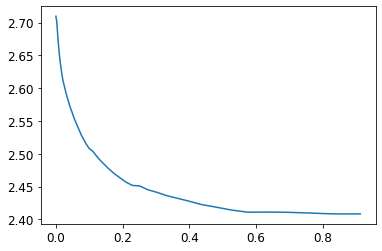

In [12]:
model = build_model(source_vocab_size, target_vocab_size, target_vocab_start, target_vocab_end, max_target_length, n_neurons=16, learning_rate=1e-6)
best_learning_rate = find_best_learning_rate(preprocessed_train_set, preprocessed_val_set, model, learning_rate_min=1e-5, learning_rate_max=1e1, n_steps=150)
best_learning_rate

In [13]:
model = build_model(source_vocab_size, target_vocab_size, target_vocab_start, target_vocab_end, max_target_length, n_neurons=64, learning_rate=1e-2)
train_model(preprocessed_train_set, preprocessed_val_set, model, n_epochs=100)

Epoch 1/100
156/156 [==============================] - 5s 22ms/step - loss: 1.6610 - sparse_categorical_accuracy: 0.3927 - val_loss: 1.7464 - val_sparse_categorical_accuracy: 0.4128
Epoch 2/100
156/156 [==============================] - 3s 22ms/step - loss: 1.1864 - sparse_categorical_accuracy: 0.5360 - val_loss: 1.6786 - val_sparse_categorical_accuracy: 0.5191
Epoch 3/100
156/156 [==============================] - 3s 21ms/step - loss: 0.5597 - sparse_categorical_accuracy: 0.7963 - val_loss: 0.6098 - val_sparse_categorical_accuracy: 0.8320
Epoch 4/100
156/156 [==============================] - 3s 21ms/step - loss: 0.2001 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.2378 - val_sparse_categorical_accuracy: 0.9545
Epoch 5/100
156/156 [==============================] - 3s 19ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.3751 - val_sparse_categorical_accuracy: 0.9441
Epoch 6/100
156/156 [==============================] - 3s 19ms/step - loss: 0.0410 - spars

In [14]:
def categorical_to_target_string(seq):
    vocab = target_preprocessor.get_vocabulary()
    return "".join([vocab[i] for i in seq])

for X, Y in preprocessed_val_set.take(1):
    Y_pred = model(X)
    for b in range(Y_pred.shape[0]):
        seq = tf.math.argmax(Y_pred[b], axis=1)
        s_target = categorical_to_target_string(Y[b])
        s_pred = categorical_to_target_string(seq)
        print("target", s_target, "pred", s_pred)

target 6130-10-03$ pred 6130-10-03$
target 5796-01-07$ pred 5796-01-07$
target 7162-04-03$ pred 7162-04-03$
target 818-10-25$ pred 818-10-25$
target 220-08-15$ pred 220-08-15$
target 4633-05-25$ pred 4633-05-25$
target 5331-11-28$ pred 5331-11-28$
target 7239-04-03$ pred 7239-04-03$
target 6618-10-07$ pred 6618-10-07$
target 7772-07-07$ pred 7772-07-07$
target 1871-10-08$ pred 1871-10-08$
target 4703-08-17$ pred 4703-08-17$
target 4700-01-01$ pred 4700-01-01$
target 2903-05-09$ pred 2903-05-09$
target 8328-10-07$ pred 8328-10-07$
target 2553-04-10$ pred 2553-04-10$
target 1928-12-15$ pred 1928-12-15$
target 4349-12-28$ pred 4349-12-28$
target 3550-01-18$ pred 3550-01-18$
target 4755-06-10$ pred 4755-06-10$
target 6141-09-03$ pred 6141-09-03$
target 9186-09-25$ pred 9186-09-25$
target 3527-06-14$ pred 3527-06-14$
target 8946-01-23$ pred 8946-01-23$
target 8310-04-10$ pred 8310-04-10$
target 6563-09-20$ pred 6563-09-20$
target 5875-11-05$ pred 5875-11-05$
target 1214-01-26$ pred 1214-01-

In [15]:
model.evaluate(preprocessed_test_set)

31/31 [==============================] - 1s 19ms/step - loss: 0.0260 - sparse_categorical_accuracy: 1.0000


[0.025971319526433945, 1.0]